In [1]:
#meta 10/30/2020 myCopy Ch.7 Working with Text Data
#book Introduction to ML with Python
#Andreas Muller

#task: Sentiment Analysis of Movie Reviews - with a classifier
#task: Topic Modeling in Movie Reviews
#input: reviews.csv

#$note: Focus on code examples and not on model results 

In [2]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#modeling help
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#modeling imports inline

Global vars and functions

In [4]:
#copied form mglearn

#from mglearn.plot_helpers
from matplotlib.colors import ListedColormap
cm = ListedColormap(['#0000aa', '#ff2020'])

#from mglearn.tools
def my_visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.

    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.

    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.

    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = [cm(1) if c < 0 else cm(0)
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

In [5]:
def my_heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img


In [6]:
def my_print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

# Working with Text Data
myCopy with pre-formatted reviews.csv file

## 0. myLoad Data
input: reviews.csv  
Already transformed into .csv format

Dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data

In [7]:
#movies_orig = pd.read_csv("../myData/movies.dat", delimiter='\t')
reviews_orig = pd.read_csv('../myData/reviews.csv')

# drop rows that have missing data
reviews=reviews_orig.copy()
reviews = reviews[~reviews.quote.isnull()] 
reviews = reviews[reviews.fresh != 'none'] #reduced dataset
reviews = reviews[reviews.quote.str.len() > 0]

reviews_orig.shape, reviews.shape

((13442, 9), (13419, 9))

In [8]:
#preview
reviews.head()

,critic,fresh,imdb,link,publication,quote,review_date,rtid,title
0,Derek Adams,fresh,114709,http://www.timeout.com/film/reviews/87745/toy-...,Time Out,"So ingenious in concept, design and execution ...",2009-10-04 00:00:00,9559,Toy Story
1,Richard Corliss,fresh,114709,"http://www.time.com/time/magazine/article/0,91...",TIME Magazine,The year's most inventive comedy.,2008-08-31 00:00:00,9559,Toy Story
2,David Ansen,fresh,114709,http://www.newsweek.com/id/104199,Newsweek,A winning animated feature that has something ...,2008-08-18 00:00:00,9559,Toy Story
3,Leonard Klady,fresh,114709,http://www.variety.com/review/VE1117941294.htm...,Variety,The film sports a provocative and appealing st...,2008-06-09 00:00:00,9559,Toy Story
4,Jonathan Rosenbaum,fresh,114709,http://onfilm.chicagoreader.com/movies/capsule...,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10 00:00:00,9559,Toy Story


## 1. Prep Data

Tidy data

In [9]:
reviews_tidy = reviews[['quote', 'fresh']].copy()
reviews_tidy['fresh_cat'] = reviews_tidy['fresh'].astype('category')
print(reviews_tidy.shape)
reviews_tidy.dtypes

(13419, 3)


quote          object
fresh          object
fresh_cat    category
dtype: object

In [10]:
#preview categories
print(reviews_tidy['fresh_cat'].cat.categories)
print(reviews_tidy['fresh_cat'].cat.codes)

Index(['fresh', 'rotten'], dtype='object')
0        0
1        0
2        0
3        0
4        0
        ..
13437    1
13438    1
13439    0
13440    1
13441    1
Length: 13419, dtype: int8


X and y

In [11]:
#interested in words in all rows, column 0
#this text_train
X = reviews_tidy.iloc[:,0]
X.shape

(13419,)

In [12]:
#for supervised learning
y = reviews_tidy['fresh_cat'].cat.codes.copy()
print(y.shape)
y

(13419,)


0        0
1        0
2        0
3        0
4        0
        ..
13437    1
13438    1
13439    0
13440    1
13441    1
Length: 13419, dtype: int8

In [13]:
print("Samples per class: {}".format(np.bincount(y)))

Samples per class: [8389 5030]


Split X&y into train and test datasets for supervised learning

In [14]:
# Randomly split data into two groups: a training set and a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=24)

#done - print summary 
print ("\nTotal records in learning set: {}".format(reviews_tidy.shape[0]))
print ("Total records in training set: {}".format(len(X_train)))
print ("Total records in test set: {}".format(len(X_test)))
    
#notice index after reshuffling
X_train.tail()


Total records in learning set: 13419
Total records in training set: 9393
Total records in test set: 4026


10400    There's nothing more static than a stalled fri...
3480     Film is so formulaic that virtually every plot...
8549     An extended collection of one-liners and not m...
903      Waller's witty, well-crafted yet unpretentious...
12728    [The film brings] horror home to a place where...
Name: quote, dtype: object

In [15]:
print("Samples per class, trainset: {}".format(np.bincount(y_train)))
print("Samples per class, testset: {}".format(np.bincount(y_test)))

Samples per class, trainset: [5896 3497]
Samples per class, testset: [2493 1533]


## 2. Modeling

### 2.1 Example application: Sentiment analysis of movie reviews


##### Bag-of-word for movie reviews
Representing text data as Bag of Words

<img alt="Diagram of the ULMFiT process" width="450" src="../images/bag_of_words.PNG">

In [16]:
#$note: just to fit into this notebook
text_train = X_train
text_test = X_test

In [17]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<9393x17799 sparse matrix of type '<class 'numpy.int64'>'
	with 169689 stored elements in Compressed Sparse Row format>


In [18]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 17799
First 20 features:
['000', '0014', '007', '044', '10', '100', '101', '105', '108', '10th', '11', '112', '114', '118', '11th', '12', '124', '125', '13', '131']
Features 20010 to 20030:
[]
Every 2000th feature:
['000', 'bribed', 'deficiencies', 'flabby', 'incompetent', 'military', 'prejudice', 'shatteringly', 'times']


In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.76


In [20]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.76
Best parameters:  {'C': 1}


In [21]:
X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.76


In [22]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <9393x4325 sparse matrix of type '<class 'numpy.int64'>'
	with 147225 stored elements in Compressed Sparse Row format>


In [23]:
feature_names = vect.get_feature_names()

print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['007', '10', '100', '11', '12', '13', '15', '1930s', '1933', '1940s', '1950s', '1960s', '1961', '1968', '1970s', '1979', '1985', '1993', '1995', '1998', '20', '2001', '2008', '20th', '21st', '30', '30s', '40', '45', '50s', '60s', '70s', '80s', '90', '90s', 'ability', 'able', 'abound', 'about', 'above', 'absence', 'absolute', 'absolutely', 'absorbed', 'absorbing', 'abstract', 'absurd', 'absurdist', 'absurdity', 'abuse']
Features 20010 to 20030:
[]
Every 700th feature:
['007', 'clever', 'families', 'jude', 'perhaps', 'solid', 'wedding']


In [24]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.76


##### BOW with Stop-words

In [25]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['during', 'already', 'sincere', 'because', 'now', 'everywhere', 'could', 'whom', 'others', 'due', 'whereby', 'our', 'become', 'therefore', 'every', 'in', 'than', 'itself', 'anyway', 'that', 'perhaps', 'anywhere', 'cant', 'system', 'twelve', 'describe', 'seeming', 'some', 'against', 'afterwards', 'yourselves', 'go']


In [26]:
# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<9393x4069 sparse matrix of type '<class 'numpy.int64'>'
	with 75249 stored elements in Compressed Sparse Row format>


In [27]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.75


##### BOW Rescaling the Data with tf-idf
\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.75


In [29]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset:
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over dataset:
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['characters' 'here' 'plot' 'while' 'also' 'character' 'performances'
 'script' 'audience' 'cast' 'end' 'entertainment' 'actors' 'yet' 'before'
 'tale' 'heart' 'genre' 'emotional' 'dialogue']
Features with highest tfidf: 
['standards' 'yes' 'anti' 'halloween' 'you' 'part' 'sequels' 'incredibly'
 'bloody' 'was' 'cry' 'upper' 'major' 'jude' 'friday' 'case' 'extremely'
 'as' 'bond' 'hated']


In [30]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'is' 'to' 'it' 'in' 'that' 'with' 'but' 'film' 'this'
 'as' 'movie' 'for' 'an' 'its' 'be' 'on' 'has' 'by' 'not' 'one' 'are'
 'more' 'all' 'his' 'than' 'you' 'at' 'about' 'from' 'have' 'most' 'like'
 'so' 'or' 'there' 'what' 'good' 'story' 'if' 'can' 'who' 'into' 'up' 'he'
 'much' 'time' 'out' 'comedy' 'best' 'even' 'director' 'which' 'too'
 'well' 'just' 'some' 'movies' 'no' 'they' 'action' 'funny' 'their' 'only'
 'make' 'characters' 'first' 'picture' 'way' 'when' 'made' 'was' 'will'
 'may' 'been' 'little' 'work' 'makes' 'very' 'never' 'great' 'we' 'films'
 'enough' 'us' 'new' 'here' 'any' 'doesn' 'still' 'two' 'does' 'though'
 'them' 'life' 'do' 'thriller' 'through']


#### 2.1.a Vis: Investigating model coefficients

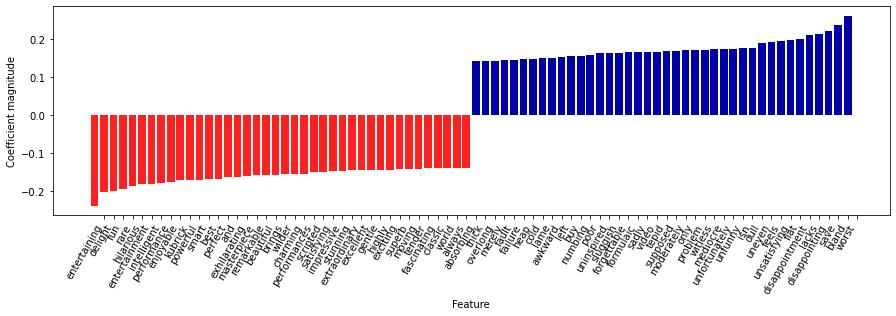

In [31]:
my_visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

##### BOW with more n-grams

In [32]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=1000))
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.76
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 3)}


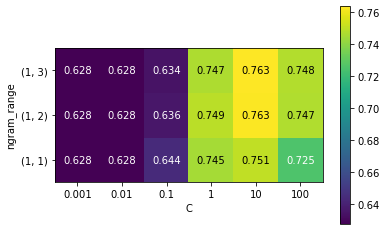

In [33]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = my_heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

#### 2.1.b Vis: Investigating model coefficients with n-grams

(-22.0, 22.0)

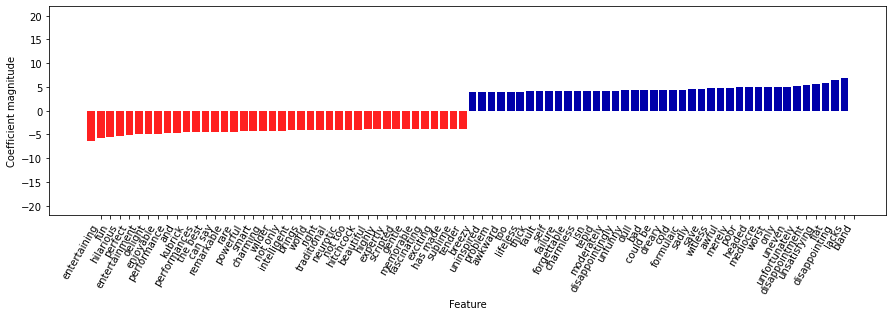

In [34]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
my_visualize_coefficients(coef, feature_names, n_top_features=40)
plt.ylim(-22, 22)

(-22.0, 22.0)

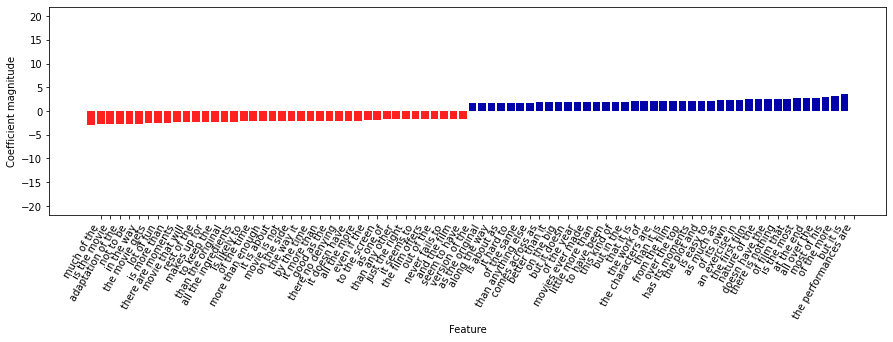

In [35]:
# find 3-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
my_visualize_coefficients(coef.ravel()[mask],
                                     feature_names[mask], n_top_features=40)
plt.ylim(-22, 22)

#### 2.1.2 Advanced tokenization, stemming and lemmatization

In [36]:
import spacy
import nltk

# load spacy's English-language models
en_nlp = spacy.load("en_core_web_sm")
# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found by spacy
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [37]:
compare_normalization(u"Our meeting today was worse than yesterday, "
                       "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


In [38]:
# Technicallity: we want to use the regexp based tokenizer
# that is used by CountVectorizer  and only use the lemmatization
# from SpaCy. To this end, we replace en_nlp.tokenizer (the SpaCy tokenizer)
# with the regexp based tokenization
import re
# regexp used in CountVectorizer:
regexp = re.compile('(?u)\\b\\w\\w+\\b')
# load spacy language model
en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
old_tokenizer = en_nlp.tokenizer
# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

# create a custom tokenizer using the SpaCy document processing pipeline
# (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [39]:
# transform text_train using CountVectorizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

# standard CountVectorizer for reference
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape: {}".format(X_train.shape))

D:\Anaconda3\envs\employee-survey-nlp\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: [W002] Tokenizer.from_list is now deprecated. Create a new Doc object instead and pass in the strings as the `words` keyword argument, for example:
from spacy.tokens import Doc
doc = Doc(nlp.vocab, words=[...])
  del sys.path[0]


X_train_lemma.shape: (9393, 3919)
X_train.shape: (9393, 4325)


In [40]:
# build a grid-search using only 1% of the data as training set:
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99,
                            train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv)
# perform grid search with standard CountVectorizer
grid.fit(X_train, y_train)
print("Best cross-validation score "
      "(standard CountVectorizer): {:.3f}".format(grid.best_score_))
# perform grid search with Lemmatization
grid.fit(X_train_lemma, y_train)
print("Best cross-validation score "
      "(lemmatization): {:.3f}".format(grid.best_score_))

Best cross-validation score (standard CountVectorizer): 0.628
Best cross-validation score (lemmatization): 0.628


### 2.2 Example application: Topic Modeling and Document Clustering
##### Latent Dirichlet Allocation

In [41]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [42]:
#$mychange was n_topics -> n_components
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [43]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


In [44]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

In [45]:
# Print out the 10 topics:
my_print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
he            as            as            you           as            
as            an            an            movie         an            
has           has           its           if            for           
his           its           at            one           this          
be            well          movie         this          about         
on            by            are           be            movie         
this          on            from          can           its           
not           so            for           not           all           
one           for           this          what          than          
have          not           all           best          more          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
for 

In [46]:
mystop
#code below breaks
#ok to move on, if fix needed look into misaligned indices

NameError: name 'mystop' is not defined

In [ ]:
lda20 = LatentDirichletAllocation(n_components=20, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics20 = lda20.fit_transform(X)

In [ ]:
topics = np.array([2, 3, 5, 7, 11, 13, 17, 19])

In [ ]:
sorting = np.argsort(lda20.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
my_print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

In [ ]:
for idx in music[:10]:
    print (idx in text_train.index)

In [ ]:
# sort by weight of "music" topic 45
music = np.argsort(document_topics20[:, 17])[::-1]
# print the five documents where the topic is most important
for i in music[:10]:
    # show first two sentences
    print(".".join(text_train[i].split(".")[:2]) + ".\n")

In [ ]:
# sort by weight of "music" topic 45
music = np.argsort(document_topics20[:, 45])[::-1]
# print the five documents where the topic is most important
for i in music[:10]:
    # show first two sentences
    print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

### Summary and Outlook